# EMU, DES, VIKING, CATWISE tile distribution and coverage

## Libraries

In [170]:
import pandas as pd

import numpy as np

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization.wcsaxes.patches import Quadrangle
from astropy.wcs import WCS
from astropy.table import Table

from bs4 import BeautifulSoup

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mplPolygon, Patch
from matplotlib.patches import CirclePolygon
from matplotlib.text import Annotation
from matplotlib import path

from shapely.geometry import Polygon as splyPolygon
from shapely.geometry import MultiPolygon
from shapely.ops import unary_union

import numpy as np

from collections import defaultdict

import json

## Tile creator

In [107]:
def corners_column_creator(tile_df, ra_size, dec_size):

    # Detect RA format
    ra_sample = str(tile_df['ra'].iloc[0])
    ra_unit = u.hourangle if ':' in ra_sample else u.deg

    # Tile centers as SkyCoord
    tile_coords = SkyCoord(ra=tile_df['ra'].values,
                           dec=tile_df['dec'].values,
                           unit=(ra_unit, u.deg),
                           frame='icrs')

    # Define corner offsets
    half_ra = ra_size / 2
    half_dec = dec_size / 2
    corner_offsets = [
        (-half_ra, -half_dec),  # Bottom-left
        ( half_ra, -half_dec),  # Bottom-right
        ( half_ra,  half_dec),  # Top-right
        (-half_ra,  half_dec),  # Top-left
    ]

    # Initialize corner arrays
    corner_ras_deg = []
    corner_decs_deg = []
    corner_ras_rad = []
    corner_decs_rad = []

    # Compute corners
    for d_ra, d_dec in corner_offsets:
        offset_angle = np.hypot(d_ra, d_dec) * u.deg
        pa = np.arctan2(d_ra, d_dec) * u.rad
        corner = tile_coords.directional_offset_by(pa, offset_angle)

        # Degrees
        ra_deg = corner.ra.wrap_at(180 * u.deg).deg
        dec_deg = corner.dec.deg

        # Radians
        ra_rad = corner.ra.wrap_at(180 * u.deg).rad
        dec_rad = corner.dec.rad

        corner_ras_deg.append(ra_deg)
        corner_decs_deg.append(dec_deg)
        corner_ras_rad.append(ra_rad)
        corner_decs_rad.append(dec_rad)

    # Assign columns: both deg and rad versions
    for i in range(4):
        tile_df[f'rac{i+1}_deg'] = corner_ras_deg[i]
        tile_df[f'decc{i+1}_deg'] = corner_decs_deg[i]
        tile_df[f'rac{i+1}_rad'] = corner_ras_rad[i]
        tile_df[f'decc{i+1}_rad'] = corner_decs_rad[i]

    # Store tile centers (deg only, already wrapped)
    tile_df['center_ra_deg'] = tile_coords.ra.wrap_at(180 * u.deg).deg
    tile_df['center_dec_deg'] = tile_coords.dec.deg

    return tile_df


In [66]:
def create_tile_polygon_list(tile_df, tile_color):

    # Extract RA and Dec corners (in radians)
    rac_rad = tile_df[['rac1_rad', 'rac2_rad', 'rac3_rad', 'rac4_rad']].values
    decc_rad = tile_df[['decc1_rad', 'decc2_rad', 'decc3_rad', 'decc4_rad']].values

    # Build list of matplotlib polygons
    polygon_list = [
        mplPolygon(list(zip(ra_row, dec_row)), closed=True, edgecolor=tile_color, facecolor='none')
        for ra_row, dec_row in zip(rac_rad, decc_rad)
    ]

    print(len(polygon_list), "polygons created")
    return polygon_list


In [ ]:
def unwrap_ra_for_polygon(ra_vals):
    """Unwrap RA values to avoid crossing the Mollweide ±π wraparound."""
    ra_vals = np.array(ra_vals)
    ra_vals = (ra_vals + np.pi) % (2 * np.pi) - np.pi  # Wrap to [-π, π]
    ra_unwrapped = ra_vals.copy()

    for i in range(1, len(ra_vals)):
        delta = ra_unwrapped[i] - ra_unwrapped[i - 1]
        if delta > np.pi:
            ra_unwrapped[i:] -= 2 * np.pi
        elif delta < -np.pi:
            ra_unwrapped[i:] += 2 * np.pi

    return ra_unwrapped


def plot_tiles(tile_df, survey_name, tile_color='blue'):

    # Extract corner columns
    rac_rad = tile_df[['rac1_rad', 'rac2_rad', 'rac3_rad', 'rac4_rad']].values
    decc_rad = tile_df[['decc1_rad', 'decc2_rad', 'decc3_rad', 'decc4_rad']].values

    # Create plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='mollweide')

    for ra_row, dec_row in zip(rac_rad, decc_rad):
        ra_unwrapped = unwrap_ra_for_polygon(ra_row)

        # Optionally close the polygon
        ra_unwrapped = np.append(ra_unwrapped, ra_unwrapped[0])
        dec_row = np.append(dec_row, dec_row[0])

        poly = mplPolygon(
            list(zip(ra_unwrapped, dec_row)),
            closed=True,
            edgecolor=tile_color,
            facecolor='none',
            linewidth=1.0
        )
        ax.add_patch(poly)

    ax.set_title(f'{survey_name} Tile Map', fontsize=16)
    ax.set_xlabel('RA (degrees)', fontsize=12)
    ax.set_ylabel('Dec (degrees)', fontsize=12)
    ax.grid(True)

    plt.subplots_adjust(top=0.95, bottom=0.05)
    plt.show()



In [138]:
def unwrap_polygon_ra(poly):
    """Unwrap polygon RA coordinates to avoid crossing ±π boundary for Mollweide."""
    def unwrap_coords(coords):
        coords = np.array(coords)
        ra = coords[:,0]
        dec = coords[:,1]

        ra_unwrapped = (ra + np.pi) % (2 * np.pi) - np.pi  # Wrap to [-π, π]
        for i in range(1, len(ra_unwrapped)):
            delta = ra_unwrapped[i] - ra_unwrapped[i - 1]
            if delta > np.pi:
                ra_unwrapped[i:] -= 2 * np.pi
            elif delta < -np.pi:
                ra_unwrapped[i:] += 2 * np.pi
        return list(zip(ra_unwrapped, dec))

    if isinstance(poly, splyPolygon):
        exterior = unwrap_coords(poly.exterior.coords)
        interiors = [unwrap_coords(ring.coords) for ring in poly.interiors]
        return splyPolygon(exterior, interiors)

    elif isinstance(poly, MultiPolygon):
        return MultiPolygon([unwrap_polygon_ra(p) for p in poly.geoms])

    else:
        return poly  # Return as-is if unknown geometry type

def divide_polygons_by_region(tile_df, polygon_list):
    """Divide polygons into 5 sky regions and compute outlines."""

    # Wrap RA to [-180, 180] degrees for logical checks
    ra_deg = ((tile_df['center_ra_deg'] + 180) % 360) - 180
    dec_deg = tile_df['center_dec_deg']

    # Initialize containers
    region1_polys = []  # Near Dec ≈ -30°
    region2_polys = []  # Near Dec ≈ 0°, RA ≈ 30°
    region3_polys = []  # Near Dec ≈ 0°, RA ∈ [120°, 150°]
    region4a_polys = [] # Near Dec ≈ 0°, RA ∈ [150°, 180°]
    region4b_polys = [] # Near Dec ≈ 0°, RA ∈ [-180°, -150°]

    for i in range(len(tile_df)):
        ra = ra_deg.iloc[i]
        dec = dec_deg.iloc[i]

        # Get corners (already in radians for Mollweide)
        corners_rad = [
            (
                tile_df[f'rac{j}_rad'][i],
                tile_df[f'decc{j}_rad'][i]
            )
            for j in range(1, 5)
        ]

        shapely_poly = splyPolygon(corners_rad)

        if -40 < dec < -20:
            region1_polys.append(shapely_poly)
        elif -10 < dec < 10 and 20 < ra < 40:
            region2_polys.append(shapely_poly)
        elif -10 < dec < 10 and 120 < ra < 150:
            region3_polys.append(shapely_poly)
        elif -15 < dec < 15 and 150 < ra <= 179:
            region4a_polys.append(shapely_poly)
        elif -15 < dec < 15 and -180 <= ra < -120:
            region4b_polys.append(shapely_poly)

    # Union all polygons per region
    region1_outline = unary_union(MultiPolygon(region1_polys)) if region1_polys else None
    region2_outline = unary_union(MultiPolygon(region2_polys)) if region2_polys else None
    region3_outline = unary_union(MultiPolygon(region3_polys)) if region3_polys else None
    region4a_outline = unary_union(MultiPolygon(region4a_polys)) if region4a_polys else None
    region4b_outline = unary_union(MultiPolygon(region4b_polys)) if region4b_polys else None

        # Unwrap RA coordinates for Mollweide plotting
    if region1_outline:
        region1_outline = unwrap_polygon_ra(region1_outline)
    if region2_outline:
        region2_outline = unwrap_polygon_ra(region2_outline)
    if region3_outline:
        region3_outline = unwrap_polygon_ra(region3_outline)
    if region4a_outline:
        region4a_outline = unwrap_polygon_ra(region4a_outline)
    if region4b_outline:
        region4b_outline = unwrap_polygon_ra(region4b_outline)

    return region1_outline, region2_outline, region3_outline, region4a_outline, region4b_outline


## EMU tiles

### Load EMU html file

In [38]:
# Load the HTML file

filename = '/home/polaris/Lab_Astro/data/survey_data/EMU_data/EMU_tiles_full.html'
with open(filename, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

# Find the table in the HTML (assuming there's only one table)
table = soup.find('table')

# Extract table headers (if any)
headers = []
for th in table.find_all('th'):
    headers.append(th.text.strip())

# Extract table rows
rows = []
for tr in table.find_all('tr'):
    cells = tr.find_all('td')
    if len(cells) > 0:
        row = [cell.text.strip() for cell in cells]
        rows.append(row)

# Convert the table data into a pandas DataFrame
emu_tiles_df = pd.DataFrame(rows, columns=headers)

# Convert 'sbid' column to integer type
emu_tiles_df['sbid'] = pd.to_numeric(emu_tiles_df['sbid'], errors='coerce').astype('Int64')

# Convert 'obs_length' column to float type
emu_tiles_df['obs_length'] = pd.to_numeric(emu_tiles_df['obs_length'], errors='coerce').astype('float')

has_sbid = emu_tiles_df['sbid'].notna()

emu_tiles_df.columns

Index(['field_name', 'ra', 'dec', 'pa', 'sbid', 'observe_date', 'obs_length',
       'release_date ▴'],
      dtype='object')

Convert the RA in hh:mm:ss and DEC in dd:mm:ss to degrees and save results in new columns ra_deg; dec_deg

In [49]:
emu_tiles_df = corners_column_creator(emu_tiles_df, ra_size=5, dec_size=5, save_in_radians=True)

emu_tiles_df.columns = emu_tiles_df.columns.str.encode('ascii', errors='ignore').str.decode('ascii')

updated_catalog_table = Table.from_pandas(emu_tiles_df)
updated_catalog_table.write('/home/polaris/Lab_Astro/data/survey_data/EMU_data/EMU_tiles.fits', overwrite=True)

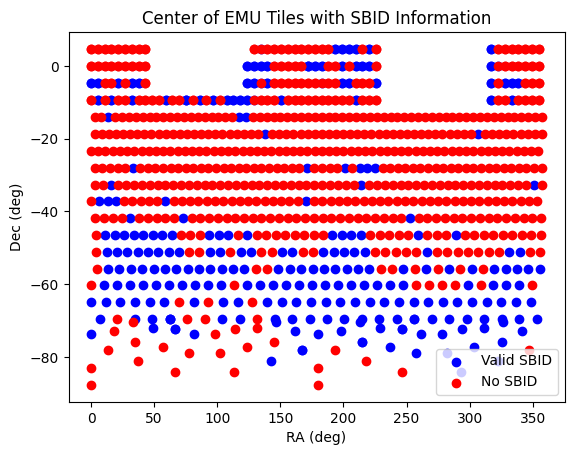

In [50]:
# Plot points with different colors based on whether 'sbid' is valid
plt.scatter(emu_tiles_df.loc[has_sbid, 'center_ra_deg'], emu_tiles_df.loc[has_sbid, 'center_dec_deg'], color='blue', label='Valid SBID')
plt.scatter(emu_tiles_df.loc[~has_sbid, 'center_ra_deg'], emu_tiles_df.loc[~has_sbid, 'center_dec_deg'], color='red', label='No SBID')

plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('Center of EMU Tiles with SBID Information')
plt.legend()
plt.show()

### Plot the actual tiles around the centers for EMU

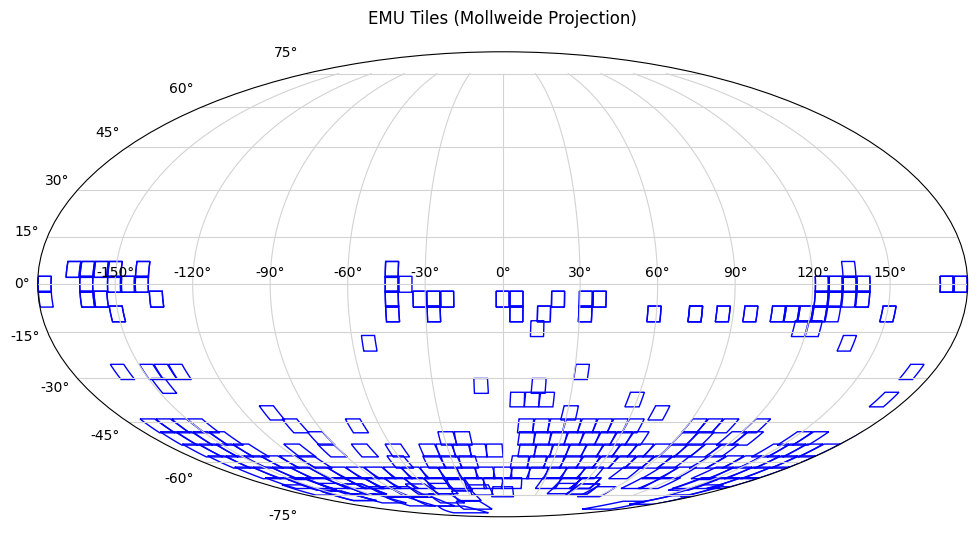

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='mollweide')

for i in range(len(emu_tiles_df)):
    ra_corners = np.array([emu_tiles_df[f'rac{j}_rad'][i] for j in range(1, 5)])
    dec_corners = np.array([emu_tiles_df[f'decc{j}_rad'][i] for j in range(1, 5)])

    if has_sbid[i]:
        ra_corners = unwrap_ra_for_polygon(ra_corners)

        # Close polygon by repeating the first point (optional but safe)
        ra_corners = np.append(ra_corners, ra_corners[0])
        dec_corners = np.append(dec_corners, dec_corners[0])

        polygon = mplPolygon(
            list(zip(ra_corners, dec_corners)),
            closed=True,
            edgecolor='blue',
            facecolor='none',
            linewidth=1.0
        )
        ax.add_patch(polygon)

ax.grid(True, color='lightgray')
ax.set_title("EMU Tiles (Mollweide Projection)", pad=20)
plt.subplots_adjust(top=0.95, bottom=0.05)
plt.show()

## DES DR1 tiles

In [18]:
des_tiles_path = '/home/polaris/Lab_Astro/data/survey_data/DES_data/des_dr1.tile_info.fits'

# Create a data frame for the DES tiles (makes it more acessible)
with fits.open(des_tiles_path) as hdul:
    des_tiles_data = hdul[1].data

des_tiles_df = pd.DataFrame(des_tiles_data)


In [19]:
# Create a SkyCoord object for the center of the DES tiles
des_center_coords = SkyCoord(ra=des_tiles_df['ra_cent'], dec=des_tiles_df['dec_cent'], unit=(u.deg, u.deg))

# Create a list of the field name and the corresponding SkyCoord object of the center of the field
des_tiles_dic = dict(zip(des_tiles_df['tilename'], des_center_coords))

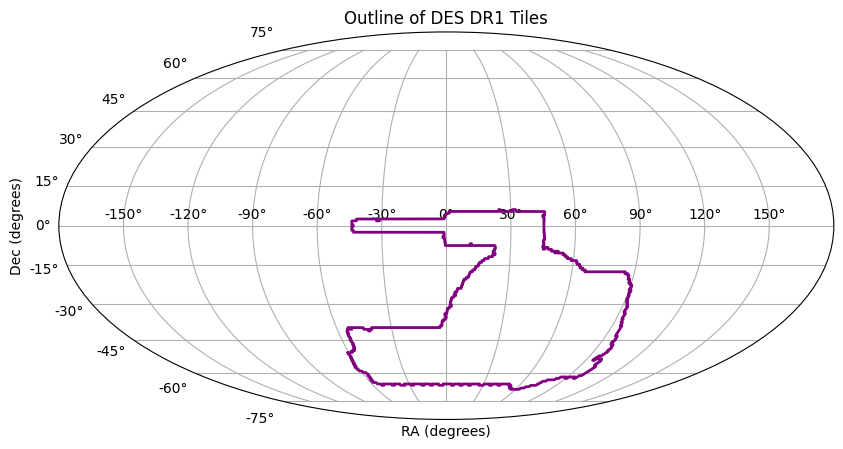

In [20]:
des_tiles_rad = []
for i in range(len(des_tiles_df)):

    corners_deg = [
        (des_tiles_df['rac1'][i],des_tiles_df['decc1'][i]),
        (des_tiles_df['rac2'][i],des_tiles_df['decc2'][i]),
        (des_tiles_df['rac3'][i],des_tiles_df['decc3'][i]),
        (des_tiles_df['rac4'][i],des_tiles_df['decc4'][i])
    ]

    # Shift RA values to center the plot at RA = 0 and convert to radians
    corners_rad = [(  np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]
    des_tiles_rad.append(splyPolygon(corners_rad))

all_tiles = MultiPolygon(des_tiles_rad)

outline = unary_union(all_tiles)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

for geom in outline.geoms if hasattr(outline, 'geoms') else [outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=2)

ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('Outline of DES DR1 Tiles')
ax.grid(True)

plt.show()

## VIKING DR4 tiles

In [98]:
viking_tiles_path_1 = '/home/polaris/Lab_Astro/data/survey_data/VIKING_data/viking_dr4_tileset.fits'
viking_tiles_path_2 = '/home/polaris/Lab_Astro/data/survey_data/VIKING_data/viking_dr4_tileset_2.fits'

viking_df = Table.read(viking_tiles_path_2).to_pandas()

In [108]:
viking_df =  corners_column_creator(viking_df, 1.5, 1.0)

print(viking_df.columns)

Index(['tileSetID', 'CUEVENTID', 'ra', 'dec', 'CX', 'CY', 'CZ', 'HTMID',
       'TLMFID', 'O1MFID', 'O2MFID', 'O3MFID', 'O4MFID', 'O5MFID', 'O6MFID',
       'MERGESWVERSION', 'NEWFRAMESET', 'DEPRECATED', 'rac1', 'rac2', 'rac3',
       'rac4', 'decc1', 'decc2', 'decc3', 'decc4', 'rac1_deg', 'decc1_deg',
       'rac2_deg', 'decc2_deg', 'rac3_deg', 'decc3_deg', 'rac4_deg',
       'decc4_deg', 'center_ra_deg', 'center_dec_deg', 'rac1_rad', 'decc1_rad',
       'rac2_rad', 'decc2_rad', 'rac3_rad', 'decc3_rad', 'rac4_rad',
       'decc4_rad'],
      dtype='object')


In [140]:
region1_outline, region2_outline, region3_outline, region4a_outline, region4b_outline = divide_polygons_by_region(viking_df, create_tile_polygon_list(viking_df, tile_color='red'))

7008 polygons created


In [139]:
viking_tile_list = create_tile_polygon_list(viking_df, 'red')

7008 polygons created


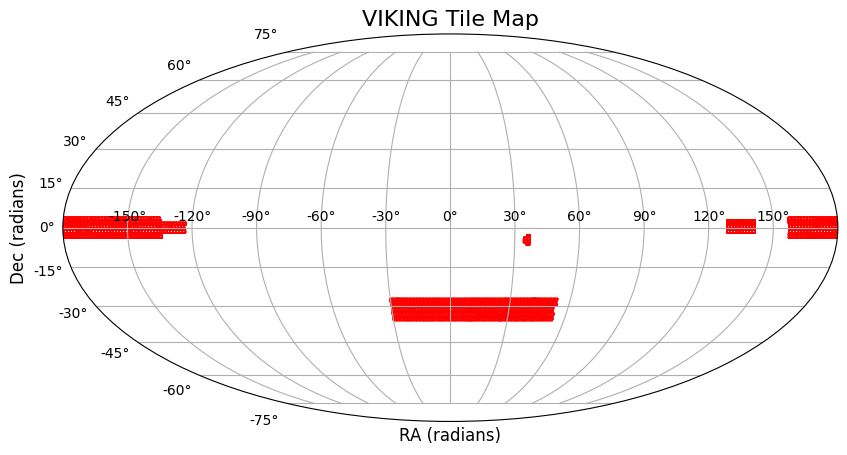

In [76]:
plot_tiles(viking_df, 'VIKING', tile_color='red')

## VHS DR6 tiles

In [ ]:
vhs_tiles_path = '/home/polaris/Lab_Astro/data/survey_data/VHS_data/vhs_dr6_tileset.fits'

In [ ]:
# Before running check if the file already has the corners columns
# corners_column_creator(vhs_tiles_path, 1.5, 1.0)

In [ ]:
vhs_tile_list = create_tile_polygon_list(vhs_tiles_path, 'orange')

28045 polygons created


In [124]:
#plot_tiles(vhs_tiles_path, 'VHS', tile_color='orange')

## EMU + DES + VIKING

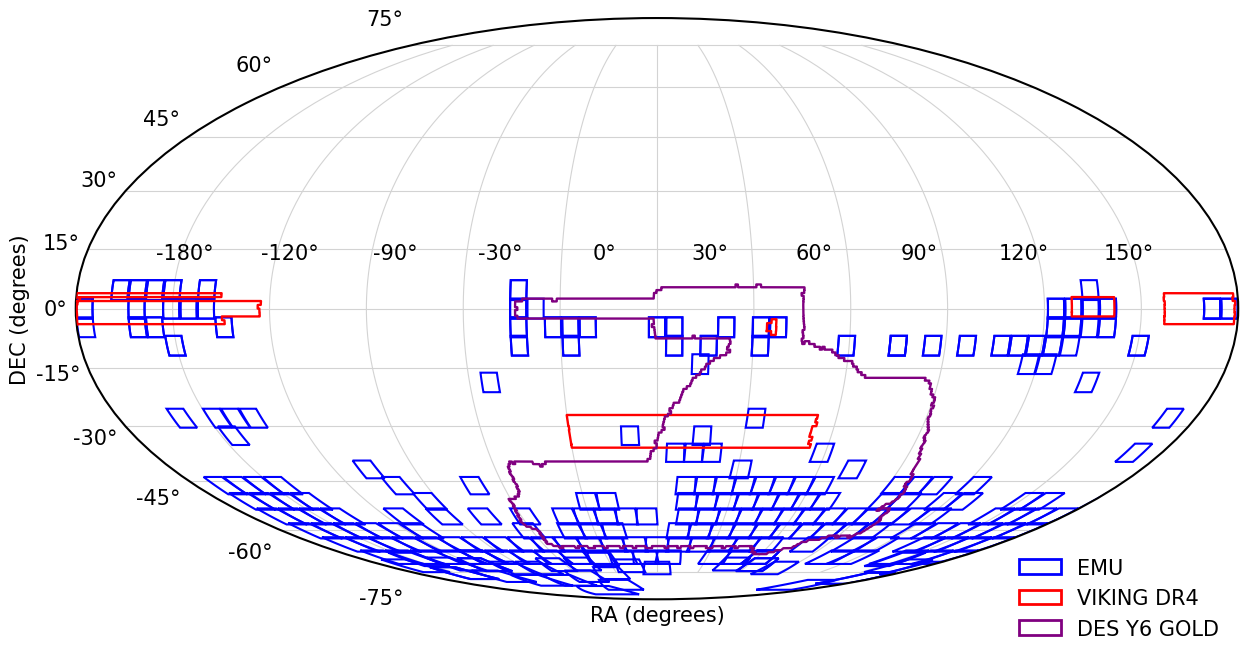

In [ ]:
# Plot the outline of the DES DR1 tiles, valid EMU tiles and VIKING tiles

# Create outline of DES tiles
all_tiles_des = MultiPolygon(des_tiles_rad)
outline_des = unary_union(all_tiles_des)


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='mollweide')

# Plot the VIKING tiles
# for viking_tile in viking_tile_list:
#     plt.gca().add_patch(viking_tile)

# Plot the outline of the VIKING tiles
for geom in region1_outline.geoms if hasattr(region1_outline, 'geoms') else [region1_outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='red', linewidth=1.7, zorder=3)
for geom in region2_outline.geoms if hasattr(region2_outline, 'geoms') else [region2_outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='red', linewidth=1.7, zorder=3)
for geom in region3_outline.geoms if hasattr(region3_outline, 'geoms') else [region3_outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='red', linewidth=1.7, zorder=3)
for geom in region4a_outline.geoms if hasattr(region4a_outline, 'geoms') else [region4a_outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='red', linewidth=1.7, zorder=3)
for geom in region4b_outline.geoms if hasattr(region4b_outline, 'geoms') else [region4b_outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='red', linewidth=1.7, zorder=3)


# Plot the outline of the DES DR1 tiles
for geom in outline_des.geoms if hasattr(outline_des, 'geoms') else [outline_des]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=1.7, zorder=3)

# Plot the valid EMU tiles
for i in range(len(emu_tiles_df)):
    ra_corners = np.array([emu_tiles_df[f'rac{j}_rad'][i] for j in range(1, 5)])
    dec_corners = np.array([emu_tiles_df[f'decc{j}_rad'][i] for j in range(1, 5)])

    if has_sbid[i]:
        ra_corners = unwrap_ra_for_polygon(ra_corners)

        # Close polygon by repeating the first point (optional but safe)
        ra_corners = np.append(ra_corners, ra_corners[0])
        dec_corners = np.append(dec_corners, dec_corners[0])

        polygon = mplPolygon(
            list(zip(ra_corners, dec_corners)),
            closed=True,
            edgecolor='blue',
            facecolor='none',
            linewidth=1.5,
            zorder=2
        )
        plt.gca().add_patch(polygon)

# Euclid Deep Field Fornax
# euclid = CirclePolygon((0.78, -0.48), radius=0.17)
# plt.gca().add_patch(euclid)

ax.tick_params(axis='y', labelsize=15)

# Remove default RA tick labels
ax.set_xticklabels([])

# Add custom RA tick labels slightly higher
tick_locs = np.radians(np.linspace(-150, 150, 10))  # RA ticks in radians
tick_labels = ['-180°', '-120°', '-90°', '-30°', '0°', '30°', '60°', '90°', '120°', '150°']  # Adjust as needed

for x, label in zip(tick_locs, tick_labels):
    ax.text(x, -0.95, label, transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=15)

ax.set_xlabel('RA (degrees)', fontsize=15)
ax.set_ylabel('DEC (degrees)',  fontsize=15)
#ax.set_title('Released EMU Tiles, Outline of DES DR2 Tiles and VIKING Tiles')
ax.grid(True, color='lightgray', zorder=0)
    

legend_patches = [
        Patch(edgecolor='blue', facecolor='none', label='EMU', linewidth=2),
        Patch(edgecolor='red', facecolor='none', label='VIKING DR4', linewidth=2),
        Patch(edgecolor='purple', facecolor='none', label='DES Y6 GOLD', linewidth=2),
    ]

ax.legend(
    handles=legend_patches,
    loc='lower right',
    bbox_to_anchor=(1.0, -0.1),
    fontsize=15,
    frameon=False
)

for spine in ax.spines.values():
    spine.set_linewidth(1.5)  # Adjust thickness (default is ~0.8)

plt.show()

## EMU + DES + VHS

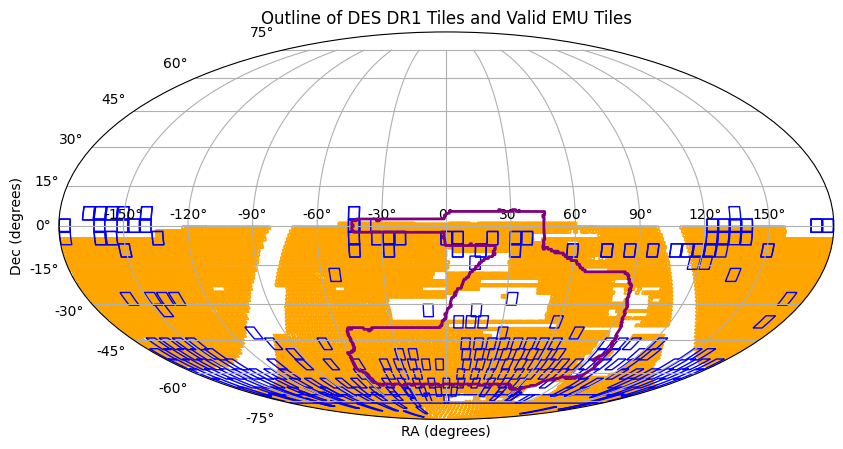

In [ ]:
# Plot the outline of the DES DR1 tiles, valid EMU tiles and VHS tiles

all_tiles = MultiPolygon(des_tiles_rad)

outline = unary_union(all_tiles)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

# Plot the VHS tiles
for vhs_tile in vhs_tile_list:
    plt.gca().add_patch(vhs_tile)

# Plot the outline of the DES DR1 tiles
for geom in outline.geoms if hasattr(outline, 'geoms') else [outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=2)

# Plot the valid EMU tiles
for i in range(len(emu_tiles_df['field_name'])):
    corners_deg = np.array([
        [emu_tiles_df['rac1_deg'][i], emu_tiles_df['decc1_deg'][i]],
        [emu_tiles_df['rac2_deg'][i], emu_tiles_df['decc2_deg'][i]],
        [emu_tiles_df['rac3_deg'][i], emu_tiles_df['decc3_deg'][i]],
        [emu_tiles_df['rac4_deg'][i], emu_tiles_df['decc4_deg'][i]]
    ])

    corners_rad = [(  np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]

    if has_sbid[i]:
        tile = mplPolygon(corners_rad, closed=True, edgecolor='blue', facecolor='none')
        plt.gca().add_patch(tile)

# Euclid Deep Field Fornax
# euclid = CirclePolygon((0.78, -0.48), radius=0.17)
# plt.gca().add_patch(euclid)

ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('Outline of DES DR1 Tiles and Valid EMU Tiles')
ax.grid(True)

plt.show()

## Check for overlap of the DES tiles on EMU

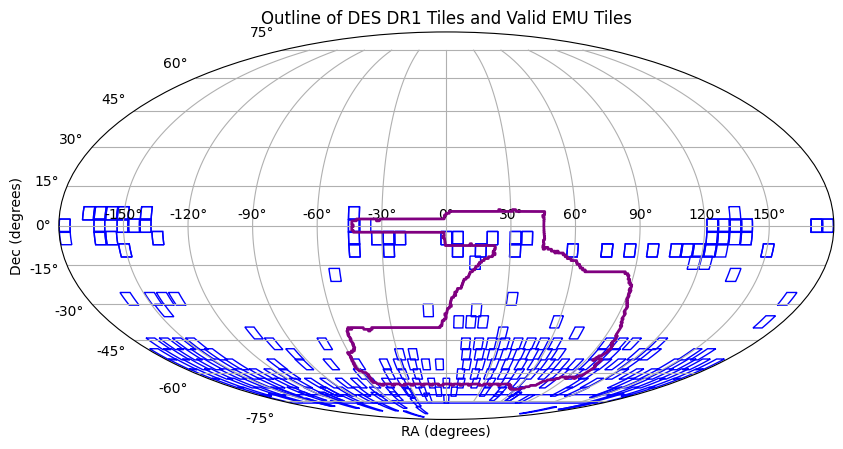

In [ ]:
# Plot the outline of the DES DR1 tiles and valid EMU tiles

all_tiles = MultiPolygon(des_tiles_rad)

outline = unary_union(all_tiles)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

# Plot the outline of the DES DR1 tiles
for geom in outline.geoms if hasattr(outline, 'geoms') else [outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=2)

# Plot the valid EMU tiles
for i in range(len(emu_tiles_df['field_name'])):
    corners_deg = np.array([
        [emu_tiles_df['rac1_deg'][i], emu_tiles_df['decc1_deg'][i]],
        [emu_tiles_df['rac2_deg'][i], emu_tiles_df['decc2_deg'][i]],
        [emu_tiles_df['rac3_deg'][i], emu_tiles_df['decc3_deg'][i]],
        [emu_tiles_df['rac4_deg'][i], emu_tiles_df['decc4_deg'][i]]
    ])

    corners_rad = [(  np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]

    if has_sbid[i]:
        tile = mplPolygon(corners_rad, closed=True, edgecolor='blue', facecolor='none')
        plt.gca().add_patch(tile)


# Euclid Deep Field Fornax
# euclid = CirclePolygon((0.78, -0.48), radius=0.17)
# plt.gca().add_patch(euclid)

ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('Outline of DES DR1 Tiles and Valid EMU Tiles')
ax.grid(True)

plt.show()


Number of EMU candidates: 135


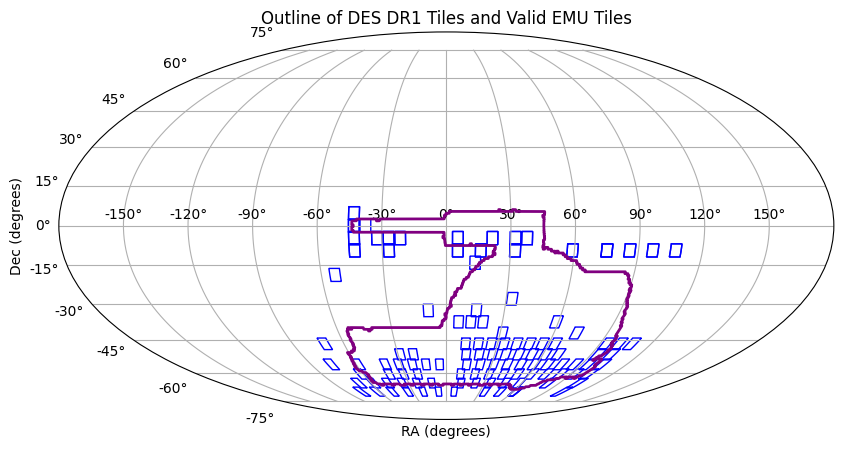

In [ ]:
# Aproximated borders of DES DR1
ra_min1 = 0
ra_max1 = 110

ra_min2 = 280

dec_min = -70.0
dec_max = 10.0

# Find EMU tiles that are within the aproximated DES DR1 borders
emu_tiles_candidates = []

for i in range(len(emu_tiles_df['field_name'])):
    if has_sbid[i]:
        if ((emu_tiles_df['center_ra_deg'][i] > ra_min1 and emu_tiles_df['center_ra_deg'][i] < ra_max1) or (emu_tiles_df['center_ra_deg'][i] > ra_min2)) and emu_tiles_df['center_dec_deg'][i] > dec_min and emu_tiles_df['center_dec_deg'][i] < dec_max:
            emu_tiles_candidates.append(emu_tiles_df['field_name'][i])

print(f'Number of EMU candidates: {len(emu_tiles_candidates)}')

# Plot the outline of the DES DR1 tiles and candidates EMU tiles
all_tiles = MultiPolygon(des_tiles_rad)

outline = unary_union(all_tiles)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')

# Plot the outline of the DES DR1 tiles
for geom in outline.geoms if hasattr(outline, 'geoms') else [outline]:
    ra, dec = geom.exterior.xy
    ax.plot(ra, dec, color='purple', linewidth=2)

# Plot the valid EMU tiles
for field_name in emu_tiles_candidates:
    i = emu_tiles_df.index[emu_tiles_df['field_name'] == field_name][0]

    corners_deg = np.array([
        [emu_tiles_df['rac1_deg'][i], emu_tiles_df['decc1_deg'][i]],
        [emu_tiles_df['rac2_deg'][i], emu_tiles_df['decc2_deg'][i]],
        [emu_tiles_df['rac3_deg'][i], emu_tiles_df['decc3_deg'][i]],
        [emu_tiles_df['rac4_deg'][i], emu_tiles_df['decc4_deg'][i]]
    ])

    corners_rad = [( np.radians(ra - 360 if ra > 180 else ra ), np.radians(dec)) for ra, dec in corners_deg]

    tile = mplPolygon(corners_rad, closed=True, edgecolor='blue', facecolor='none')
    plt.gca().add_patch(tile)


ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('Outline of DES DR1 Tiles and Valid EMU Tiles')
ax.grid(True)

plt.show()

In [ ]:
# Precompute SkyCoord objects for EMU and DES tiles
emu_coords = SkyCoord(ra=emu_tiles_df['center_ra_deg'], dec=emu_tiles_df['center_dec_deg'], unit=(u.deg, u.deg))
des_coords = SkyCoord(ra=des_tiles_df['ra_cent'], dec=des_tiles_df['dec_cent'], unit=(u.deg, u.deg))

# Define the search radius in degrees
search_radius = 4 * u.deg

# Initialize the result dictionary
emu_and_des = defaultdict(list)

# Iterate through all EMU tiles
for k, emu_field_name in enumerate(emu_tiles_candidates):
    # Get the index of the current EMU tile
    i = emu_tiles_df.index[emu_tiles_df['field_name'] == emu_field_name][0]

    # Get the SkyCoord object for the current EMU tile
    center_tile = emu_coords[i]

    # Filter DES tiles based on RA and Dec ranges
    ra_diff = np.abs(des_coords.ra.deg - center_tile.ra.deg)
    ra_diff = np.minimum(ra_diff, 360 - ra_diff)  # Handle RA wrapping
    dec_diff = np.abs(des_coords.dec.deg - center_tile.dec.deg)

    # Apply the RA and Dec range filters
    mask = (ra_diff <= search_radius.value) & (dec_diff <= search_radius.value)

    # Further filter by actual angular separation
    close_des_tiles = des_coords[mask]
    separations = center_tile.separation(close_des_tiles)
    within_radius = separations < search_radius

    # Add matching DES tiles to the result
    matching_des_indices = np.where(mask)[0][within_radius]
    emu_and_des[emu_field_name] = des_tiles_df['tilename'].iloc[matching_des_indices].tolist()

    # Print progress
    print(f"Processed EMU Field: {emu_field_name}")

# Print the final result
# print(emu_and_des)

# Save to text file
output_file = "/home/polaris/Lab_Astro/data/emu_and_des_results.txt"

with open(output_file, "w") as file:
    json.dump(emu_and_des, file, indent=4)

print(f"Dictionary saved to {output_file}")

Processed EMU Field: EMU_0406-60
Processed EMU Field: EMU_1921-64
Processed EMU Field: EMU_0438-51
Processed EMU Field: EMU_0429-55
Processed EMU Field: EMU_0405-51
Processed EMU Field: EMU_2237-60
Processed EMU Field: EMU_2007-64
Processed EMU Field: EMU_0352-64
Processed EMU Field: EMU_0525-64
Processed EMU Field: EMU_0208-04B
Processed EMU Field: EMU_0658-64
Processed EMU Field: EMU_2129+00A
Processed EMU Field: EMU_0230-04B
Processed EMU Field: EMU_0356-09A
Processed EMU Field: EMU_0125-04A
Processed EMU Field: EMU_0356-09B
Processed EMU Field: EMU_0125-04B
Processed EMU Field: EMU_0355-37
Processed EMU Field: EMU_0543-09B
Processed EMU Field: EMU_0614-46
Processed EMU Field: EMU_0500-09A
Processed EMU Field: EMU_0325-60
Processed EMU Field: EMU_0026-37
Processed EMU Field: EMU_0616-51
Processed EMU Field: EMU_0021-04B
Processed EMU Field: EMU_0104-09B
Processed EMU Field: EMU_0021-09B
Processed EMU Field: EMU_0244-60
Processed EMU Field: EMU_0649-51
Processed EMU Field: EMU_0709-0

In [ ]:
# The plotting order of the patches is inverse to the order they are show.

def plot_intersect(emu_field_name, des_tile_list):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    
    # Define EMU tile
    # Find the index of the EMU tile
    i = emu_tiles_df.index[emu_tiles_df['field_name'] == emu_field_name][0]

    # Get EMU tile center and wrap RA to [-180, 180]
    emu_ra_center = (emu_tiles_df['center_ra_deg'][i] + 180) % 360 - 180
    emu_dec_center = emu_tiles_df['center_dec_deg'][i]

    # Plot the DES tiles
    for j in range(len(des_tiles_df)):
        #  Wrap RA to [-180, 180]
        des_corners_deg = [
            ((des_tiles_df['rac1'][j] + 180) % 360 - 180, des_tiles_df['decc1'][j]),
            ((des_tiles_df['rac2'][j] + 180) % 360 - 180, des_tiles_df['decc2'][j]),
            ((des_tiles_df['rac3'][j] + 180) % 360 - 180, des_tiles_df['decc3'][j]),
            ((des_tiles_df['rac4'][j] + 180) % 360 - 180, des_tiles_df['decc4'][j])
        ]

        if des_tiles_df['tilename'][j] in des_tile_list:
            des_polygon = mplPolygon(des_corners_deg, closed=True, edgecolor='green', facecolor='none', linewidth=2)
        else:
            des_polygon = mplPolygon(des_corners_deg, closed=True, edgecolor='red', facecolor='none')
        
        ax.add_patch(des_polygon)

    # Plot the EMU tile
    emu_corners_deg = np.array([
        [(emu_tiles_df['rac1_deg'][i] + 180) % 360 - 180, emu_tiles_df['decc1_deg'][i]],
        [(emu_tiles_df['rac2_deg'][i] + 180) % 360 - 180, emu_tiles_df['decc2_deg'][i]],
        [(emu_tiles_df['rac3_deg'][i] + 180) % 360 - 180, emu_tiles_df['decc3_deg'][i]],
        [(emu_tiles_df['rac4_deg'][i] + 180) % 360 - 180, emu_tiles_df['decc4_deg'][i]]
    ])

    emu_polygon = mplPolygon(emu_corners_deg, closed=True, edgecolor='blue', facecolor='none', linewidth=2)
    ax.add_patch(emu_polygon)

    # Set limits of the plot
    ra_min_deg = emu_ra_center - 10
    ra_max_deg = emu_ra_center + 10
    dec_min_deg = emu_dec_center - 10
    dec_max_deg = emu_dec_center + 10

    ax.set_title(f'EMU and DES Tiles (Zoomed-In on {emu_field_name})', fontsize=14)
    ax.set_xlabel('RA (degrees)')
    ax.set_ylabel('DEC (degrees)')
    
    ax.set_xlim(ra_min_deg, ra_max_deg)
    ax.set_ylim(dec_min_deg, dec_max_deg)
   
    image_path = '/home/polaris/Lab_Astro/data/matched_data/des_tiles/' + str(emu_field_name) + '.png'

    plt.savefig(image_path)

    print('Imaged saved to: ', image_path)

EMU Field: EMU_0406-60
DES Tiles: ['DES0416-6122', 'DES0422-6122', 'DES0402-6331', 'DES0353-6205', 'DES0359-6205', 'DES0359-5831', 'DES0405-6205', 'DES0411-6205', 'DES0417-6205', 'DES0353-5748', 'DES0407-5622', 'DES0354-5831', 'DES0405-5831', 'DES0410-5831', 'DES0416-5831', 'DES0401-6248', 'DES0407-6248', 'DES0413-6248', 'DES0413-5705', 'DES0419-5705', 'DES0358-5748', 'DES0404-5748', 'DES0351-6039', 'DES0352-6122', 'DES0358-6122', 'DES0404-6122', 'DES0410-6122', 'DES0355-5957', 'DES0357-6039', 'DES0356-6331', 'DES0409-6331', 'DES0415-6331', 'DES0401-5957', 'DES0407-5957', 'DES0402-6039', 'DES0408-6039', 'DES0421-6331', 'DES0413-5957', 'DES0418-5957', 'DES0414-6039', 'DES0402-5622', 'DES0420-6039', 'DES0355-5914', 'DES0400-5914', 'DES0406-5914', 'DES0411-5914', 'DES0417-5914', 'DES0419-6248', 'DES0354-6248', 'DES0404-6414', 'DES0411-6414', 'DES0421-5831', 'DES0358-5705', 'DES0403-5705', 'DES0408-5705', 'DES0409-5748', 'DES0414-5748', 'DES0420-5748', 'DES0352-5705']


FileNotFoundError: [Errno 2] No such file or directory: '/home/polaris/Lab_Astro/data/matched_data/des_tiles/EMU_0406-60.png'

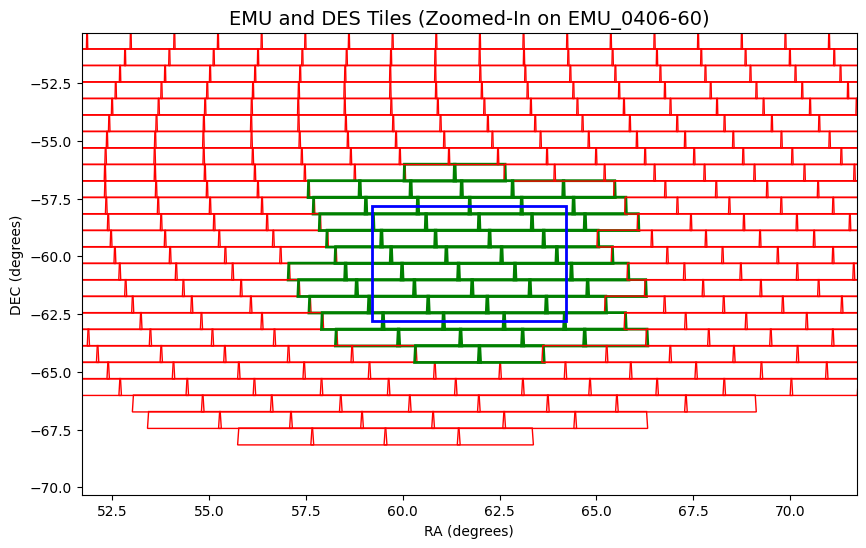

In [ ]:
for i in range(128):
    emu_field, des_tiles = list(emu_and_des.items())[i]
    print(f'EMU Field: {emu_field}')
    print(f'DES Tiles: {des_tiles}')
    plot_intersect(emu_field, des_tiles)